<a href="https://colab.research.google.com/github/sancara/DataEngineer/blob/main/Examen_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Problema
La Administración Nacional de Aviación Civil necesita una serie de informes para elevar al
ministerio de transporte acerca de los aterrizajes y despegues en todo el territorio Argentino,
como puede ser: cuales aviones son los que más volaron, cuántos pasajeros volaron, ciudades
de partidas y aterrizajes entre fechas determinadas, etc.
Usted como data engineer deberá realizar un pipeline con esta información, automatizarlo y
realizar los análisis de datos solicitados que permita responder las preguntas de negocio, y
hacer sus recomendaciones con respecto al estado actual.

- Listado de vuelos realizados:
https://datos.transporte.gob.ar/dataset/aterrizajes-despegues-procesados-por-administracion-nacional-aviacion-civil-anac
- Listado de detalles de aeropuertos de Argentina:
https://datos.transporte.gob.ar/dataset/lista-aeropuertos


# Tareas
1. Ingest
  - [Informe 2021](https://datos.transporte.gob.ar/dataset/21038a1a-c3c7-4494-b76a-3a2a8fbb83b5/resource/1b4f569a-cab0-4560-993c-5bf96c3e7cf0/download/2021-informe-ministerio.csv)
  - [Informe 2022](https://data-engineer-edvai.s3.amazonaws.com/202206-informe-ministerio.csv)
  - [Detalles Aeropuerto](https://datos.transporte.gob.ar/dataset/62b3fe5f-ffe6-4d8f-9d59-bfabe75d1ee8/resource/eb54e49e-9a5a-4614-91f4-526c650d0105/download/aeropuertos_detalle.csv)
2. Realizar un proceso automático orquestado por airflow que ingeste los archivos previamente
mencionados entre las fechas 01/01/2021 y 30/06/2022
3. Realizar las siguiente transformaciones en los pipelines de datos:
  - Eliminar la columna inhab ya que no se utilizará para el análisis
  - Eliminar la columna fir ya que no se utilizará para el análisis
  - Eliminar la columna “calidad del dato” ya que no se utilizará para el análisis
  - Filtrar los vuelos internacionales ya que solamente se analizarán los vuelos domésticos
  - En el campo pasajeros si se encuentran campos en Null convertirlos en 0 (cero)
  - En el campo distancia_ref si se encuentran campos en Null convertirlos en 0 (cero)
4. Mostrar mediante una impresión de pantalla, que los tipos de campos de las tablas sean los
solicitados en el datawarehouse (ej: fecha date, aeronave string, pasajeros integer, etc.)
5. Determinar la cantidad de vuelos entre las fechas 01/12/2021 y 31/01/2022. Mostrar consulta y
Resultado de la query
6. Cantidad de pasajeros que viajaron en Aerolíneas Argentinas entre el 01/01/2021 y 30/06/2022.
Mostrar consulta y Resultado de la query
7. Mostrar fecha, hora, código aeropuerto salida, ciudad de salida, código de aeropuerto de arribo,
ciudad de arribo, y cantidad de pasajeros de cada vuelo, entre el 01/01/2022 y el 30/06/2022
ordenados por fecha de manera descendiente. Mostrar consulta y Resultado de la query
8. Cuales son las 10 aerolíneas que más pasajeros llevaron entre el 01/01/2021 y el 30/06/2022
exceptuando aquellas aerolíneas que no tengan nombre. Mostrar consulta y Visualización
9. Cuales son las 10 aeronaves más utilizadas entre el 01/01/2021 y el 30/06/22 que despegaron
desde la Ciudad autónoma de Buenos Aires o de Buenos Aires, exceptuando aquellas aeronaves
que no cuentan con nombre. Mostrar consulta y Visualización.
10. Qué datos externos agregaría en este dataset que mejoraría el análisis de los datos


## Ingest
1. Realizo ingesta de archivos
2. Genero un dataframe por archivo
3. Casteo de columnas a tipo de dato solicitado
4. Renombro las columnas
5. Print de schema 

In [1]:
!wget https://datos.transporte.gob.ar/dataset/21038a1a-c3c7-4494-b76a-3a2a8fbb83b5/resource/1b4f569a-cab0-4560-993c-5bf96c3e7cf0/download/2021-informe-ministerio.csv
!wget https://data-engineer-edvai.s3.amazonaws.com/202206-informe-ministerio.csv
!wget https://datos.transporte.gob.ar/dataset/62b3fe5f-ffe6-4d8f-9d59-bfabe75d1ee8/resource/eb54e49e-9a5a-4614-91f4-526c650d0105/download/aeropuertos_detalle.csv

--2022-12-03 02:03:17--  https://datos.transporte.gob.ar/dataset/21038a1a-c3c7-4494-b76a-3a2a8fbb83b5/resource/1b4f569a-cab0-4560-993c-5bf96c3e7cf0/download/2021-informe-ministerio.csv
Resolving datos.transporte.gob.ar (datos.transporte.gob.ar)... 190.220.16.243
Connecting to datos.transporte.gob.ar (datos.transporte.gob.ar)|190.220.16.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32322556 (31M) [text/csv]
Saving to: ‘2021-informe-ministerio.csv’

2021-informe-minist 100%[===================>]  30.82M  5.64MB/s    in 6.5s    

2022-12-03 02:03:24 (4.76 MB/s) - ‘2021-informe-ministerio.csv’ saved [32322556/32322556]

--2022-12-03 02:03:24--  https://data-engineer-edvai.s3.amazonaws.com/202206-informe-ministerio.csv
Resolving data-engineer-edvai.s3.amazonaws.com (data-engineer-edvai.s3.amazonaws.com)... 54.231.129.201, 52.217.110.84, 54.231.129.73, ...
Connecting to data-engineer-edvai.s3.amazonaws.com (data-engineer-edvai.s3.amazonaws.com)|54.231.129.201|

In [2]:
# Spark import and session creation
!pip3 install pyspark py4j
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("edvai") \
    .getOrCreate()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 44 kB/s 
     |████████████████████████████████| 200 kB 42.5 MB/s 
     |████████████████████████████████| 199 kB 15.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=524cd7ea3ba317af84c843f10e7f46e44ef93560a6d3815a43f546851f65b8f7
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [3]:
from pyspark.sql.functions import to_date

df_2021 = spark.read.option("header", "true").csv("./2021-informe-ministerio.csv", sep =";")
df_2021 = df_2021.withColumn('fecha', to_date(df_2021.Fecha, 'dd/MM/yyyy'))\
          .withColumn('pasajeros', df_2021.Pasajeros.cast('int'))\
          .withColumnRenamed('Hora UTC', 'horaUTC')\
          .withColumnRenamed('Clase de Vuelo (todos los vuelos)', 'clase_de_vuelo')\
          .withColumnRenamed('Clasificación Vuelo', 'clasificacion_vuelo')\
          .withColumnRenamed('Tipo de Movimiento', 'tipo_de_movimiento')\
          .withColumnRenamed('Aeropuerto', 'aeropuerto')\
          .withColumnRenamed('Origen / Destino', 'origen_destino')\
          .withColumnRenamed('Aerolinea Nombre', 'aerolinea_nombre')\
          .withColumnRenamed('Aeronave', 'aeronave')
          
df_2021.printSchema()
df_2021.show(5)

root
 |-- fecha: date (nullable = true)
 |-- horaUTC: string (nullable = true)
 |-- clase_de_vuelo: string (nullable = true)
 |-- clasificacion_vuelo: string (nullable = true)
 |-- tipo_de_movimiento: string (nullable = true)
 |-- aeropuerto: string (nullable = true)
 |-- origen_destino: string (nullable = true)
 |-- aerolinea_nombre: string (nullable = true)
 |-- aeronave: string (nullable = true)
 |-- pasajeros: integer (nullable = true)
 |-- Calidad dato: string (nullable = true)

+----------+-------+--------------------+-------------------+------------------+----------+--------------+--------------------+----------------+---------+------------+
|     fecha|horaUTC|      clase_de_vuelo|clasificacion_vuelo|tipo_de_movimiento|aeropuerto|origen_destino|    aerolinea_nombre|        aeronave|pasajeros|Calidad dato|
+----------+-------+--------------------+-------------------+------------------+----------+--------------+--------------------+----------------+---------+------------+
|2021-0

In [4]:
df_2022 = spark.read.option("header", "true").csv("./202206-informe-ministerio.csv", sep = ";")
df_2022 = df_2022.withColumn('fecha',to_date(df_2022.Fecha, 'dd/MM/yyyy'))\
          .withColumn('pasajeros', df_2022.Pasajeros.cast('int'))\
          .withColumnRenamed('Hora UTC', 'horaUTC')\
          .withColumnRenamed('Clase de Vuelo (todos los vuelos)', 'clase_de_vuelo')\
          .withColumnRenamed('Clasificación Vuelo', 'clasificacion_vuelo')\
          .withColumnRenamed('Tipo de Movimiento', 'tipo_de_movimiento')\
          .withColumnRenamed('Aeropuerto', 'aeropuerto')\
          .withColumnRenamed('Origen / Destino', 'origen_destino')\
          .withColumnRenamed('Aerolinea Nombre', 'aerolinea_nombre')\
          .withColumnRenamed('Aeronave', 'aeronave')

df_2022.printSchema()
df_2022.show(5)

root
 |-- fecha: date (nullable = true)
 |-- horaUTC: string (nullable = true)
 |-- clase_de_vuelo: string (nullable = true)
 |-- clasificacion_vuelo: string (nullable = true)
 |-- tipo_de_movimiento: string (nullable = true)
 |-- aeropuerto: string (nullable = true)
 |-- origen_destino: string (nullable = true)
 |-- aerolinea_nombre: string (nullable = true)
 |-- aeronave: string (nullable = true)
 |-- pasajeros: integer (nullable = true)
 |-- Calidad dato: string (nullable = true)

+----------+-------+--------------+-------------------+------------------+----------+--------------+--------------------+------------+---------+------------+
|     fecha|horaUTC|clase_de_vuelo|clasificacion_vuelo|tipo_de_movimiento|aeropuerto|origen_destino|    aerolinea_nombre|    aeronave|pasajeros|Calidad dato|
+----------+-------+--------------+-------------------+------------------+----------+--------------+--------------------+------------+---------+------------+
|2022-01-01|  00:01|       Regular|  

In [5]:
df_aeropuertos = spark.read.option("header", "true").csv("./aeropuertos_detalle.csv", sep = ";")
df_aeropuertos = df_aeropuertos.withColumn('elev', df_aeropuertos.elev.cast('float'))\
                .withColumn('distancia_ref', df_aeropuertos.distancia_ref.cast('float'))\
                .withColumnRenamed('local','aeropuerto')\
                .withColumnRenamed('oaci','oac')
df_aeropuertos.printSchema()
df_aeropuertos.show(5)

root
 |-- aeropuerto: string (nullable = true)
 |-- oac: string (nullable = true)
 |-- iata: string (nullable = true)
 |-- tipo: string (nullable = true)
 |-- denominacion: string (nullable = true)
 |-- coordenadas: string (nullable = true)
 |-- latitud: string (nullable = true)
 |-- longitud: string (nullable = true)
 |-- elev: float (nullable = true)
 |-- uom_elev: string (nullable = true)
 |-- ref: string (nullable = true)
 |-- distancia_ref: float (nullable = true)
 |-- direccion_ref: string (nullable = true)
 |-- condicion: string (nullable = true)
 |-- control: string (nullable = true)
 |-- region: string (nullable = true)
 |-- fir: string (nullable = true)
 |-- uso: string (nullable = true)
 |-- trafico: string (nullable = true)
 |-- sna: string (nullable = true)
 |-- concesionado: string (nullable = true)
 |-- provincia: string (nullable = true)
 |-- inhab: string (nullable = true)

+----------+----+----+---------+--------------------+--------------------+------------+---------

In [6]:
!wget https://final-exam-edvai.s3.amazonaws.com/etl.py

--2022-12-03 02:04:41--  https://final-exam-edvai.s3.amazonaws.com/etl.py
Resolving final-exam-edvai.s3.amazonaws.com (final-exam-edvai.s3.amazonaws.com)... 52.216.140.140, 52.217.44.132, 52.217.94.212, ...
Connecting to final-exam-edvai.s3.amazonaws.com (final-exam-edvai.s3.amazonaws.com)|52.216.140.140|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2022-12-03 02:04:41 ERROR 403: Forbidden.



## ETL Pyspark

In [7]:
from pyspark.sql.functions import col


df_fechas = df_2021.union(df_2022)
df_fechas = df_fechas.drop(col('Calidad dato')).na.fill(0,["pasajeros"])

df_fechas.printSchema()

root
 |-- fecha: date (nullable = true)
 |-- horaUTC: string (nullable = true)
 |-- clase_de_vuelo: string (nullable = true)
 |-- clasificacion_vuelo: string (nullable = true)
 |-- tipo_de_movimiento: string (nullable = true)
 |-- aeropuerto: string (nullable = true)
 |-- origen_destino: string (nullable = true)
 |-- aerolinea_nombre: string (nullable = true)
 |-- aeronave: string (nullable = true)
 |-- pasajeros: integer (nullable = true)



In [8]:
vuelos_domesticos = df_fechas.filter(df_fechas.clasificacion_vuelo == 'Domestico')
vuelos_domesticos.show(5)

+----------+-------+--------------------+-------------------+------------------+----------+--------------+--------------------+----------------+---------+
|     fecha|horaUTC|      clase_de_vuelo|clasificacion_vuelo|tipo_de_movimiento|aeropuerto|origen_destino|    aerolinea_nombre|        aeronave|pasajeros|
+----------+-------+--------------------+-------------------+------------------+----------+--------------+--------------------+----------------+---------+
|2021-01-01|  00:02|Vuelo Privado con...|          Domestico|          Despegue|       PAR|           ROS|                   0|    PA-PA-28-181|        0|
|2021-01-01|  00:24|             Regular|          Domestico|        Aterrizaje|       EZE|           GRA|AEROLINEAS ARGENT...|     BO-B737-8MB|       70|
|2021-01-01|  00:26|             Regular|          Domestico|        Aterrizaje|       EZE|           ECA|AEROLINEAS ARGENT...|      BO-737-800|       70|
|2021-01-01|  00:29|             Regular|          Domestico|        A

In [9]:
df_aeropuertos = df_aeropuertos.drop(col('inhab')).drop(col('fir')).na.fill(0, ["distancia_ref"])
df_aeropuertos.printSchema()
df_aeropuertos.show()

root
 |-- aeropuerto: string (nullable = true)
 |-- oac: string (nullable = true)
 |-- iata: string (nullable = true)
 |-- tipo: string (nullable = true)
 |-- denominacion: string (nullable = true)
 |-- coordenadas: string (nullable = true)
 |-- latitud: string (nullable = true)
 |-- longitud: string (nullable = true)
 |-- elev: float (nullable = true)
 |-- uom_elev: string (nullable = true)
 |-- ref: string (nullable = true)
 |-- distancia_ref: float (nullable = false)
 |-- direccion_ref: string (nullable = true)
 |-- condicion: string (nullable = true)
 |-- control: string (nullable = true)
 |-- region: string (nullable = true)
 |-- uso: string (nullable = true)
 |-- trafico: string (nullable = true)
 |-- sna: string (nullable = true)
 |-- concesionado: string (nullable = true)
 |-- provincia: string (nullable = true)

+----------+----+----+---------+--------------------+--------------------+------------+------------+-----+--------+--------------------+-------------+-------------+---

In [10]:
vuelos_domesticos.createOrReplaceTempView('vuelos')
vuelos2021a2022 = spark.sql("SELECT count(*) as cantidad_vuelos FROM vuelos WHERE fecha BETWEEN '2021-12-01' AND '2022-01-31'")
vuelos2021a2022.show()

+---------------+
|cantidad_vuelos|
+---------------+
|          33003|
+---------------+



In [11]:
pasajeros_aerolineas = spark.sql("SELECT sum(pasajeros) as cantidad_pasajeros FROM vuelos \
                                  WHERE aerolinea_nombre == 'AEROLINEAS ARGENTINAS SA' \
                                  AND fecha BETWEEN '2021-12-01' AND '2022-06-30'")
pasajeros_aerolineas.show()

+------------------+
|cantidad_pasajeros|
+------------------+
|            634719|
+------------------+



In [12]:
df_aeropuertos.createOrReplaceTempView('aeropuertos')

In [13]:
vuelos = spark.sql("SELECT v.fecha, v.horaUTC, v.aeropuerto as aep_salida, a.ref as ciudad_salida, v.origen_destino as aep_destino, b.ref as ciudad_destino, v.pasajeros \
                    FROM vuelos v \
                    JOIN aeropuertos a ON v.aeropuerto = a.aeropuerto \
                    JOIN aeropuertos b ON v.origen_destino = b.aeropuerto \
                    WHERE v.fecha BETWEEN '2021-12-01' AND '2022-06-30' ORDER BY fecha DESC")
vuelos.show(5)

+----------+-------+----------+--------------------+-----------+--------------------+---------+
|     fecha|horaUTC|aep_salida|       ciudad_salida|aep_destino|      ciudad_destino|pasajeros|
+----------+-------+----------+--------------------+-----------+--------------------+---------+
|2021-12-31|  00:04|       CBA|             Córdoba|        BAR|San Carlos de Bar...|       71|
|2021-12-31|  00:13|       AER|Ciudad de Buenos ...|        GRA|          Río Grande|       82|
|2021-12-31|  00:07|       IGU|Cataratas del Iguazú|        AER|Ciudad de Buenos ...|       72|
|2021-12-31|  00:09|       FDO|        San Fernando|        FDO|        San Fernando|        0|
|2021-12-31|  00:10|       AER|Ciudad de Buenos ...|        POS|             Posadas|       50|
+----------+-------+----------+--------------------+-----------+--------------------+---------+
only showing top 5 rows



In [14]:
buenos_aires = vuelos.filter(vuelos.ciudad_salida == 'Ciudad de Buenos Aires').groupBy(vuelos.aep_salida).count()                                                                                                             
buenos_aires.show()


+----------+-----+
|aep_salida|count|
+----------+-----+
|       AER| 5990|
+----------+-----+



In [23]:
charged_aerolineas = spark.sql("SELECT aerolinea_nombre, sum(pasajeros) as cant_pasajeros \
                    FROM vuelos \
                    WHERE fecha BETWEEN '2021-12-01' AND '2022-06-30' AND aerolinea_nombre NOT IN (0)\
                    GROUP BY aerolinea_nombre \
                    ORDER BY cant_pasajeros DESC \
                    LIMIT 10")
charged_aerolineas.show(10)
charged_aerolineas.write.csv('Aerolineas_pasajeros.csv')

+--------------------+--------------+
|    aerolinea_nombre|cant_pasajeros|
+--------------------+--------------+
|AEROLINEAS ARGENT...|        634719|
|FB LÍNEAS AÉREAS ...|        139514|
|JETSMART AIRLINES...|        135136|
|   AMERICAN JET S.A.|          1823|
|            L.A.D.E.|          1686|
|       BAIRES FLY SA|           645|
|AIR EUROPA LINEAS...|           483|
|FUERZA AEREA ARGE...|           309|
|FUERZA AEREA ARGE...|            88|
|AERORUTAS S.A. DE...|            84|
+--------------------+--------------+



In [22]:
aeronaves = spark.sql("SELECT v.aeronave\
                       FROM vuelos v\
                       JOIN aeropuertos a ON a.aeropuerto == v.aeropuerto \
                       WHERE a.provincia IN ('CIUDAD AUTÓNOMA DE BUENOS AIRES', 'BUENOS AIRES') AND v.fecha BETWEEN '2021-12-01' AND '2022-06-30' \
                       AND v.tipo_de_movimiento == 'Despegue' \
                       AND v.aeronave NOT IN (0)\
                       GROUP BY aeronave \
                       ORDER BY v.aeronave \
                       LIMIT 10")
aeronaves.write.csv('Aeronaves.csv')
aeronaves.show(10)

+-------------+
|     aeronave|
+-------------+
|   AB-180-RVR|
|    AET-600-A|
|    AET-601-P|
|AG-A-109-A-II|
|AIB-A-330-223|
| AIB-A320-232|
| AIB-A330-202|
| AIB-A330-203|
|   AIR-AT-802|
|  AIR-AT-802A|
+-------------+



# Airflow

## Ejecución del DAG
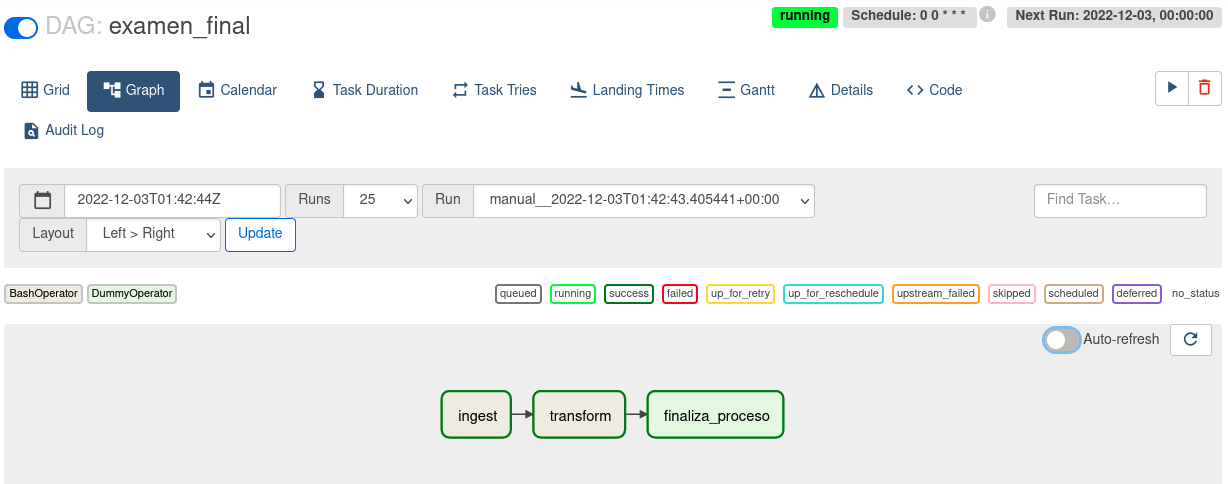

## Configuración del DAG
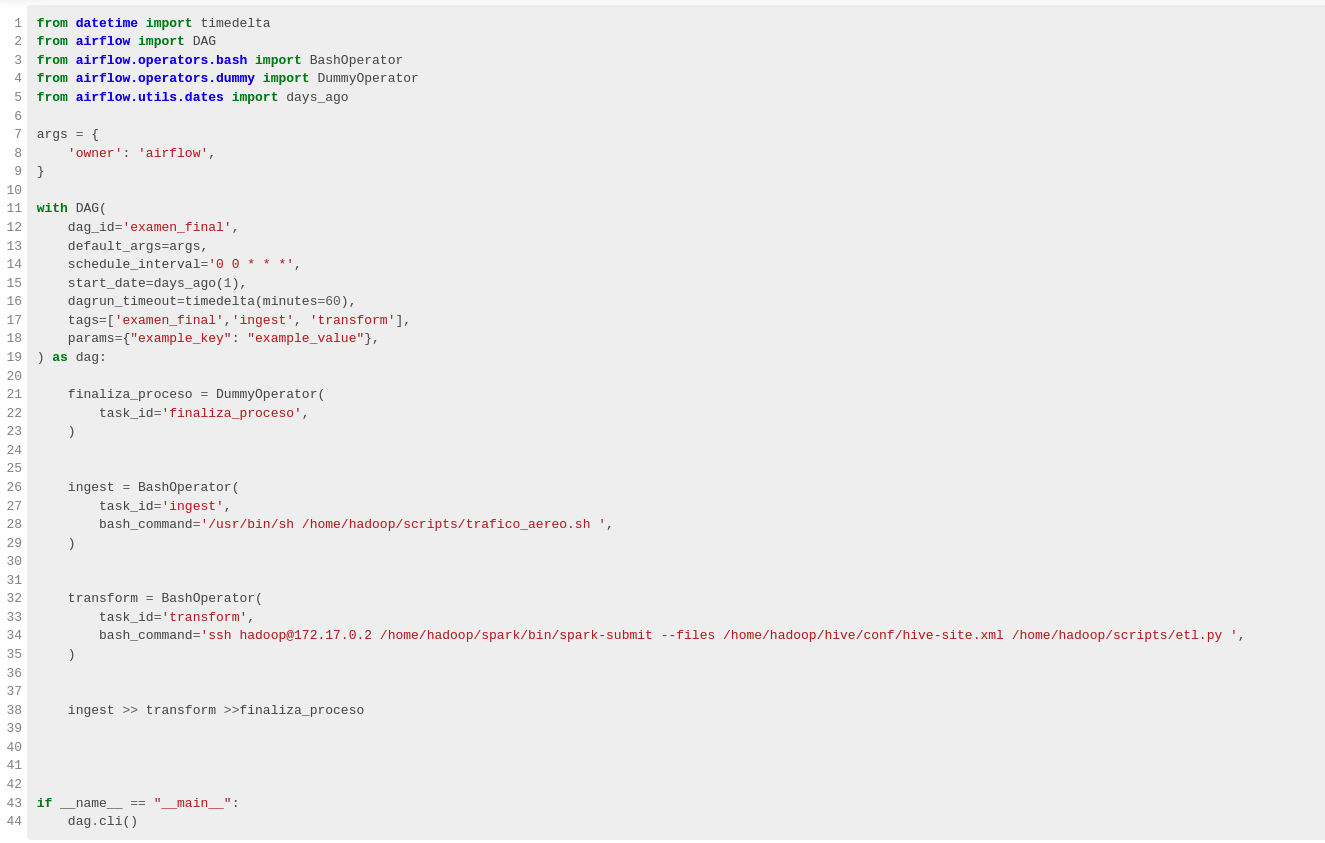

## printSchema desde el log de Airflow
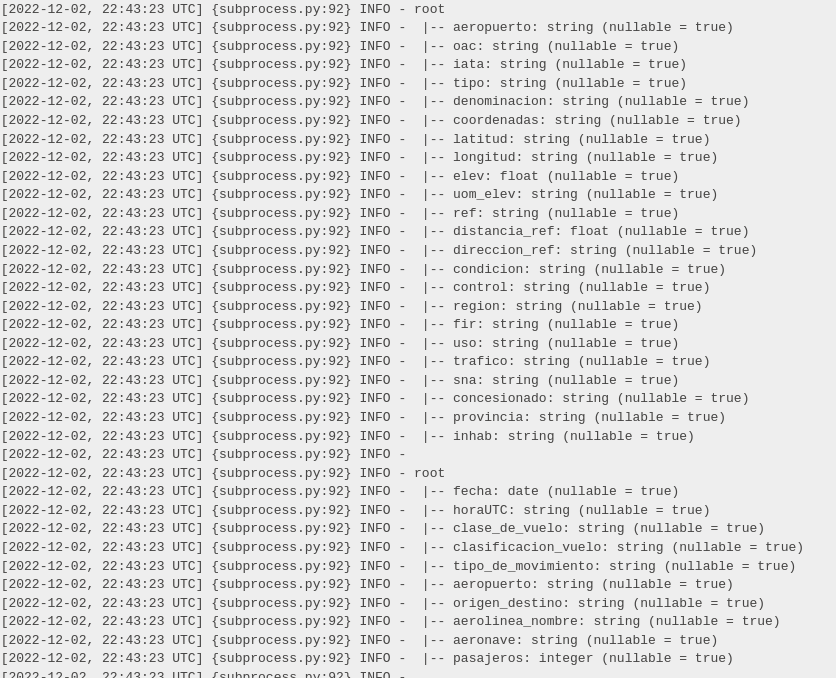

## Output de query cantidad de pasajeros por aerolínea
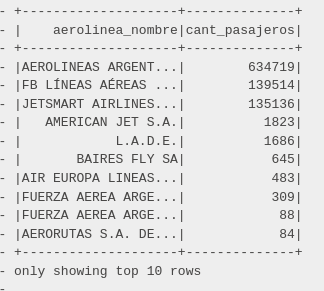

# Visualizaciones

1. [TOP 10 Aerolíneas según cantidad de pasajeros](https://datastudio.google.com/reporting/c818304b-f0da-4ec7-8a72-bd3f7cad20cb)
2. [TOP 10 Aeronaves despegando desde CABA & BA](https://datastudio.google.com/reporting/16060b33-fac9-473b-9dd7-0b292cfcbe76)

## Aerolíneas que más pasajeros llevaron entre 01-01-2021 y el 30-06-2022

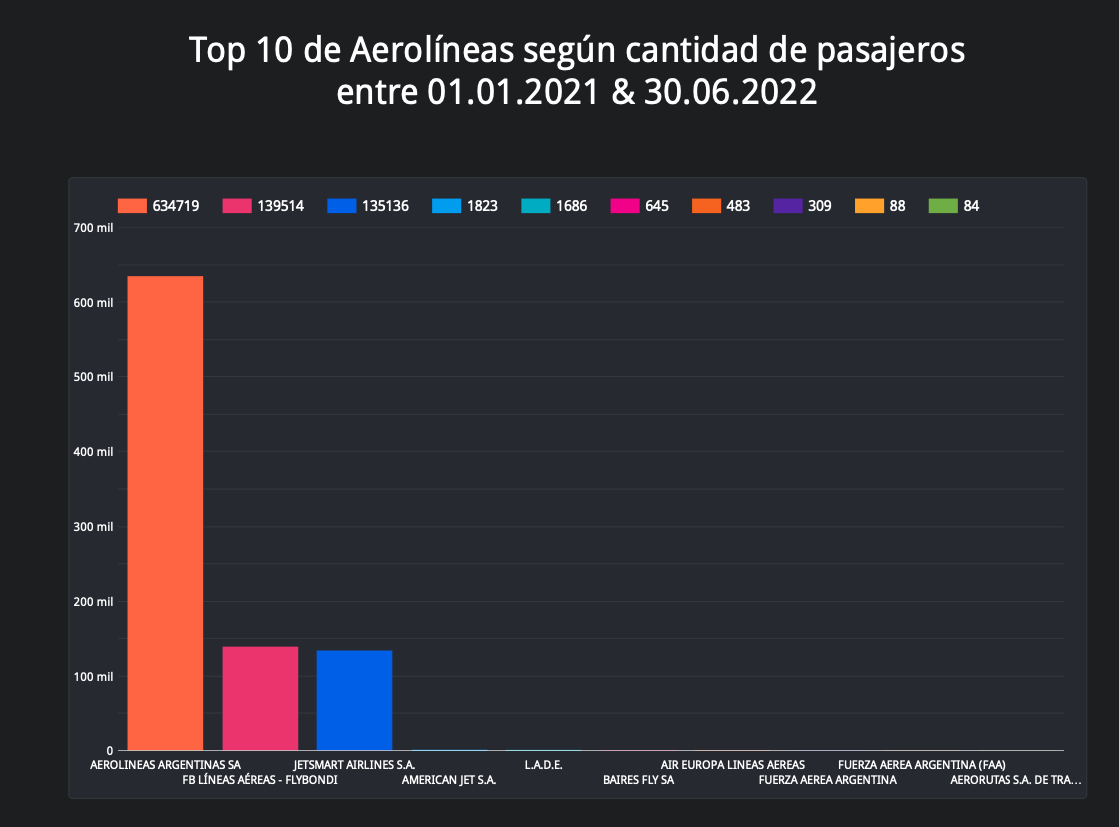

## Las 10 aeronaves más utilizadas despegando desde CABA o BA

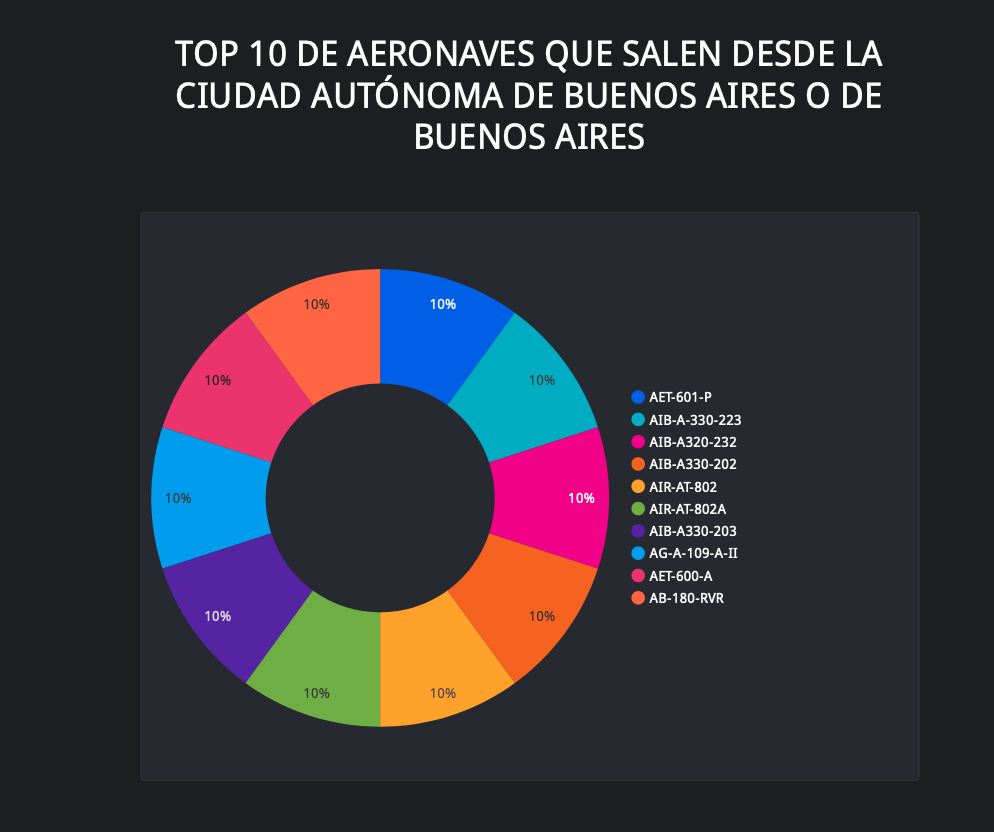

# Conclusiones

- Se distingue un amplio predominio de vuelos domésticos por parte de las empresas convencionales por sobre las lowcost.
- Las aeronaves que más despegan desde Buenos Aires en su mayoría son de la familia del Airbus 300
- Se podría sumar información de las características particulares de cada aeronave, seguridad, comfort, también cruzar datos con accidentes aéreos y qué tipos de aeronaves son las mayormente involucradas.
- Como insight futuro se podría enriquecer cada uno de los datos de vuelos, con las distancias recorridas sumando el consumo de combustible y condiciones meteorológicas, por lo cuál podríamos promediar un consumo y un costo estimado para futuros vuelos dependiendo de la distancia a recorrer y condiciones del clima.
- Suelen usarse modelos de predicción para calcular las ventas de pasajes según vuelos, venta de tickets y pasajeros que efectivamente hacen el on-boarding.